In [1]:
from datetime import datetime
start_time = datetime.now()

# Load libraries
# %pip install keras
# %pip install tensorflow

import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

print('LOAD DURATION:',datetime.now() - start_time) # about 3 minutes

LOAD DURATION: 0:00:11.996398


In [2]:
%%time
property_data = pd.read_csv('NY property data.csv')
NY_data_orig = property_data.copy()

Wall time: 3.51 s


In [3]:
property_data.shape

(1070994, 32)

In [4]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,1,2,3,4,5
BBLE,1000010101,1000010201,1000020001,1000020023,1000030001
B,1,1,1,1,1
BLOCK,1,1,2,2,3
LOT,101,201,1,23,1
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,DEPT OF GENERAL SERVI,DEPARTMENT OF BUSINES,PARKS AND RECREATION
BLDGCL,P7,Z9,Y7,T2,Q1
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,709,793,323


In [5]:
numrecs = len(property_data)

## Fill in missing ZIP

In [6]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

29890

In [7]:
for i in range(len(missing_zips)):
    if(property_data.loc[missing_zips[i]+1,'ZIP'] == property_data.loc[missing_zips[i]-1,'ZIP']):
        property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [8]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

16437

In [9]:
for i in range(len(missing_zips)):
    property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [10]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

0

## Calculate means for AVTOT, AVLAND, FULLVAL by taxclass, avoiding the records with zeros

In [11]:
property_data['FULLVAL'].replace('NaN',0)
temp =property_data[property_data['FULLVAL']!=0]
mean_fullval = temp.groupby('TAXCLASS')['FULLVAL'].mean()
print(mean_fullval)

TAXCLASS
1     5.698435e+05
1A    3.352842e+05
1B    5.613639e+05
1C    7.615359e+05
1D    2.233614e+07
2     7.998018e+05
2A    8.640037e+05
2B    1.252989e+06
2C    7.728799e+05
3     1.112765e+05
4     3.211928e+06
Name: FULLVAL, dtype: float64


In [12]:
property_data['AVLAND'].replace('NaN',0)
temp_avland = property_data[property_data['AVLAND']!=0]
mean_avland = temp_avland.groupby('TAXCLASS')['AVLAND'].mean()

In [13]:
property_data['AVTOT'].replace('NaN',0)
temp_avtot = property_data[property_data['AVTOT']!=0]
mean_avtot = temp_avtot.groupby('TAXCLASS')['AVTOT'].mean()

## Substituting decent values for AVTOT, AVLAND, FULLVAL from averages by taxclass

In [14]:
%%time
for index in mean_fullval.index:
    property_data.loc[(property_data['FULLVAL']==0)&(property_data['TAXCLASS']==index),'FULLVAL']=mean_fullval[index]
    property_data.loc[(property_data['AVLAND']==0)&(property_data['TAXCLASS']==index),'AVLAND']=mean_avland[index]
    property_data.loc[(property_data['AVTOT']==0)&(property_data['TAXCLASS']==index),'AVTOT']=mean_avtot[index]

Wall time: 2.21 s


In [15]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,1,2,3,4,5
BBLE,1000010101,1000010201,1000020001,1000020023,1000030001
B,1,1,1,1,1
BLOCK,1,1,2,2,3
LOT,101,201,1,23,1
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,DEPT OF GENERAL SERVI,DEPARTMENT OF BUSINES,PARKS AND RECREATION
BLDGCL,P7,Z9,Y7,T2,Q1
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,709,793,323


## STORIES

In [16]:
temp = property_data[property_data['STORIES'].isnull()]
len(temp)

56264

In [17]:
temp['TAXCLASS'].value_counts()

1B    24736
4     22354
3      4635
2      3435
1       897
2C      138
2B       34
2A       30
1A        5
Name: TAXCLASS, dtype: int64

In [18]:
mean_stories = property_data.groupby('TAXCLASS')['STORIES'].mean()
print(mean_stories)

TAXCLASS
1      2.111641
1A     1.656837
1B     4.000000
1C     3.052748
1D     1.068966
2     16.095110
2A     2.844574
2B     4.004494
2C     4.745097
3      1.333333
4      5.446968
Name: STORIES, dtype: float64


In [19]:
temp.head().transpose()

,0,1,5,65,66
RECORD,1,2,6,66,67
BBLE,1000010101,1000010201,1000030002,1000051004,1000051005
B,1,1,1,1,1
BLOCK,1,1,3,5,5
LOT,101,201,2,1004,1005
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,PARKS AND RECREATION,SLG BROAD STREET 125,AMERICAN CIVIL LIBERT
BLDGCL,P7,Z9,Q1,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,496,0,0


In [20]:
len(property_data[property_data["STORIES"]==0])

0

In [21]:
property_data['STORIES']=property_data['STORIES'].fillna(value =0)
for index in mean_stories.index:
    property_data.loc[(property_data['STORIES']==0)&(property_data['TAXCLASS']==index),'STORIES']=mean_stories[index]

In [22]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,1,2,3,4,5
BBLE,1000010101,1000010201,1000020001,1000020023,1000030001
B,1,1,1,1,1
BLOCK,1,1,2,2,3
LOT,101,201,1,23,1
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,DEPT OF GENERAL SERVI,DEPARTMENT OF BUSINES,PARKS AND RECREATION
BLDGCL,P7,Z9,Y7,T2,Q1
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,709,793,323


## Fill in LTFRONT, LTDEPTH, BLDDEPTH, BLDFRONT with averages by TAXCLASS

In [23]:
%%time
# as these 4 values do not have NAs, we just need to replace 0s. 
# calculate groupwise average. 1st replace 0 by NAs so they are not counted in calculating mean.
property_data.loc[property_data['LTFRONT']==0,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==0,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==0,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==0,'BLDDEPTH']=np.nan
property_data.loc[property_data['LTFRONT']==1,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==1,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==1,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

#calculate mean now (mean function ignores NAs but not 0s hence we converted 0 to NA)
mean_LTFRONT=property_data.groupby(property_data['TAXCLASS'])['LTFRONT'].mean()
mean_LTDEPTH=property_data.groupby(property_data['TAXCLASS'])['LTDEPTH'].mean()
mean_BLDFRONT=property_data.groupby(property_data['TAXCLASS'])['BLDFRONT'].mean()
mean_BLDDEPTH=property_data.groupby(property_data['TAXCLASS'])['BLDDEPTH'].mean()

#impute values
for index in mean_LTFRONT.index:
    property_data.loc[(property_data['LTFRONT'].isnull())&(property_data['TAXCLASS']==index),'LTFRONT']=mean_LTFRONT[index]    
    property_data.loc[(property_data['LTDEPTH'].isnull())&(property_data['TAXCLASS']==index),'LTDEPTH']=mean_LTDEPTH[index]
    property_data.loc[(property_data['BLDFRONT'].isnull())&(property_data['TAXCLASS']==index),'BLDFRONT']=mean_BLDFRONT[index]
    property_data.loc[(property_data['BLDDEPTH'].isnull())&(property_data['TAXCLASS']==index),'BLDDEPTH']=mean_BLDDEPTH[index]

Wall time: 3.77 s


In [24]:
mean_LTFRONT

TAXCLASS
1      30.939072
1A     51.124586
1B     54.610260
1C     27.250825
1D    338.275862
2     113.541391
2A     25.917860
2B     27.254835
2C     29.987290
3     136.107963
4      93.937119
Name: LTFRONT, dtype: float64

In [25]:
mean_LTDEPTH

TAXCLASS
1      99.282535
1A     90.083551
1B    111.856649
1C     96.778878
1D    497.827586
2     132.606230
2A     97.282675
2B     95.751182
2C     95.737463
3     280.837313
4     133.871567
Name: LTDEPTH, dtype: float64

In [26]:
mean_BLDFRONT

TAXCLASS
1     21.401447
1A    25.024532
1B    39.500000
1C    23.367589
1D    19.586207
2     92.203204
2A    22.983862
2B    26.042747
2C    27.888318
3     19.333333
4     64.439787
Name: BLDFRONT, dtype: float64

In [27]:
mean_BLDDEPTH

TAXCLASS
1      41.556940
1A     44.949251
1B     82.666667
1C     60.094862
1D     36.862069
2     108.005699
2A     62.430662
2B     66.587020
2C     68.660429
3      33.750000
4      87.820730
Name: BLDDEPTH, dtype: float64

In [28]:
data = property_data.copy()
data.shape

(1070994, 32)

In [29]:
data.dtypes

RECORD        int64
BBLE         object
B             int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT     float64
LTDEPTH     float64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT    float64
BLDDEPTH    float64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [30]:
# convert ZIP to an integer rather than a float
data['ZIP'] = data['ZIP'].astype(str)
data['zip3'] = data['ZIP'].str[:3]

In [31]:
data.count()

RECORD      1070994
BBLE        1070994
B           1070994
BLOCK       1070994
LOT         1070994
EASEMENT       4636
OWNER       1039249
BLDGCL      1070994
TAXCLASS    1070994
LTFRONT     1070994
LTDEPTH     1070994
EXT          354305
STORIES     1070994
FULLVAL     1070994
AVLAND      1070994
AVTOT       1070994
EXLAND      1070994
EXTOT       1070994
EXCD1        638488
STADDR      1070318
ZIP         1070994
EXMPTCL       15579
BLDFRONT    1070994
BLDDEPTH    1070994
AVLAND2      282726
AVTOT2       282732
EXLAND2       87449
EXTOT2       130828
EXCD2         92948
PERIOD      1070994
YEAR        1070994
VALTYPE     1070994
zip3        1070994
dtype: int64

In [32]:
cols = data.columns
print(cols)

Index(['RECORD', 'BBLE', 'B', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3'],
      dtype='object')


In [33]:
data['ltsize'] = data['LTFRONT'] * data['LTDEPTH']
data['bldsize'] = data['BLDFRONT'] * data['BLDDEPTH']
data['bldvol'] = data['bldsize'] * data['STORIES']

In [34]:
data.head().transpose()

,0,1,2,3,4
RECORD,1,2,3,4,5
BBLE,1000010101,1000010201,1000020001,1000020023,1000030001
B,1,1,1,1,1
BLOCK,1,1,2,2,3
LOT,101,201,1,23,1
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,DEPT OF GENERAL SERVI,DEPARTMENT OF BUSINES,PARKS AND RECREATION
BLDGCL,P7,Z9,Y7,T2,Q1
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,709,793,323


In [35]:
data['r1'] = data['FULLVAL'] / data['ltsize']
data['r2'] = data['FULLVAL'] / data['bldsize']
data['r3'] = data['FULLVAL'] / data['bldvol']
data['r4'] = data['AVLAND'] / data['ltsize']
data['r5'] = data['AVLAND'] / data['bldsize']
data['r6'] = data['AVLAND'] / data['bldvol']
data['r7'] = data['AVTOT'] / data['ltsize']
data['r8'] = data['AVTOT'] / data['bldsize']
data['r9'] = data['AVTOT'] / data['bldvol']

In [36]:
%%time
ninevars = ['r1','r2','r3','r4','r5','r6','r7','r8','r9']
zip5_mean = data.groupby('ZIP')[ninevars].mean()
zip3_mean = data.groupby('zip3')[ninevars].mean()
taxclass_mean = data.groupby('TAXCLASS')[ninevars].mean()
borough_mean = data.groupby('B')[ninevars].mean()
data = data.join(zip5_mean, on='ZIP', rsuffix='_zip5')
data = data.join(zip3_mean, on='zip3', rsuffix='_zip3')
data = data.join(taxclass_mean, on='TAXCLASS', rsuffix='_taxclass')
data = data.join(borough_mean, on='B', rsuffix='_boro')
rsuffix = ['_zip5', '_zip3', '_taxclass', '_boro']
for var in ninevars:
    for r in rsuffix:
        data[str(var)+r] = data[var] / data[str(var)+r]

Wall time: 2.96 s


In [37]:
data.head().transpose()

,0,1,2,3,4
RECORD,1,2,3,4,5
BBLE,1000010101,1000010201,1000020001,1000020023,1000030001
B,1,1,1,1,1
BLOCK,1,1,2,2,3
LOT,101,201,1,23,1
...,...,...,...,...,...
r5_boro,11.8983,40.2944,1.55451,5.19036,380.238
r6_boro,6.28149,21.2728,1.49007,7.46281,1093.43
r7_boro,0.199588,261.531,1.27698,0.437606,3.2636
r8_boro,11.908,107.84,0.824401,2.63567,169.028


In [38]:
data.columns

Index(['RECORD', 'BBLE', 'B', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3', 'ltsize', 'bldsize',
       'bldvol', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
       'r1_zip5', 'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5',
       'r7_zip5', 'r8_zip5', 'r9_zip5', 'r1_zip3', 'r2_zip3', 'r3_zip3',
       'r4_zip3', 'r5_zip3', 'r6_zip3', 'r7_zip3', 'r8_zip3', 'r9_zip3',
       'r1_taxclass', 'r2_taxclass', 'r3_taxclass', 'r4_taxclass',
       'r5_taxclass', 'r6_taxclass', 'r7_taxclass', 'r8_taxclass',
       'r9_taxclass', 'r1_boro', 'r2_boro', 'r3_boro', 'r4_boro', 'r5_boro',
       'r6_boro', 'r7_boro', 'r8_boro', 'r9_boro'],
      dtype='object')

In [39]:
dropcols = ['RECORD','BBLE', 'B', 'BLOCK', 'LOT', 'EASEMENT',
       'OWNER', 'BLDGCL', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES',
       'FULLVAL', 'AVLAND', 'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR',
       'ZIP', 'EXMPTCL', 'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2',
       'EXLAND2', 'EXTOT2', 'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3','ltsize','bldsize','bldvol']
data = data.drop(columns = dropcols)
data.shape

(1070994, 45)

In [40]:
data.head().transpose()

,0,1,2,3,4
r1,40.917782,53616.895011,261.796157,89.714219,669.074647
r2,3781.487225,34245.431036,261.796157,836.980890,53676.325646
r3,694.237107,6287.063144,87.265386,418.490445,53676.325646
r4,8.079350,3959.018409,97.551991,34.913021,297.434763
r5,746.667022,2528.648700,97.551991,325.717946,23861.620343
r6,137.079388,464.230514,32.517330,162.858973,23861.620343
r7,18.413002,24127.602755,117.808271,40.371399,301.083591
r8,1701.669251,15410.443966,117.808271,376.641401,24154.346541
r9,312.406698,2829.178415,39.269424,188.320700,24154.346541
r1_zip5,0.100365,131.514300,0.642147,0.220056,1.641141


In [41]:
stats = data.describe().transpose()
stats.to_csv('stats_on_vars.csv')

In [42]:
data.to_csv('NY vars.csv', index=False)
data.describe()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
count,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,...,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06
mean,2.115870e+02,5.425089e+02,2.490844e+02,1.103465e+01,2.867304e+01,1.397631e+01,2.721126e+01,5.646694e+01,2.306249e+01,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
std,6.672988e+02,2.328098e+03,1.491144e+03,1.787615e+02,9.793136e+02,6.439950e+02,2.688211e+02,1.285734e+03,7.050177e+02,2.845260e+00,...,7.488781e+00,3.036852e+00,4.283323e+00,9.630258e+00,2.146285e+01,3.080144e+01,3.608364e+01,1.154596e+01,2.347441e+01,2.545129e+01
min,3.180786e-04,7.068200e-04,8.607173e-05,8.333333e-06,2.008340e-04,1.038033e-05,8.333333e-06,3.062474e-04,6.049251e-05,1.866140e-06,...,2.902247e-06,1.888492e-06,1.230571e-06,2.940213e-07,7.831931e-07,3.200320e-06,4.756653e-07,3.577603e-07,7.027002e-06,1.813324e-06
25%,7.092457e+01,1.705387e+02,6.880088e+01,2.230459e+00,5.606622e+00,1.736443e+00,5.128400e+00,1.671733e+01,6.570424e+00,4.224821e-01,...,3.709485e-01,3.903701e-01,3.284447e-01,2.885219e-01,2.215697e-01,2.155996e-01,1.326184e-01,2.337213e-01,3.470717e-01,3.105395e-01
50%,1.503846e+02,4.933333e+02,2.348958e+02,4.556098e+00,1.487879e+01,7.083124e+00,8.485584e+00,2.681473e+01,1.258891e+01,9.042801e-01,...,8.184415e-01,8.284232e-01,9.285503e-01,8.919565e-01,6.197014e-01,6.236369e-01,5.370488e-01,4.956386e-01,6.158630e-01,5.789286e-01
75%,2.410000e+02,6.803419e+02,3.330645e+02,7.222129e+00,2.029303e+01,1.003321e+01,1.349250e+01,3.601587e+01,1.756759e+01,1.224272e+00,...,1.125055e+00,1.240560e+00,1.257970e+00,1.252535e+00,9.921710e-01,8.549833e-01,7.767476e-01,7.908525e-01,8.286982e-01,8.139676e-01
max,3.423792e+05,1.097094e+06,1.097094e+06,1.540706e+05,4.914844e+05,4.914844e+05,1.540706e+05,8.249136e+05,4.936922e+05,1.448251e+03,...,4.416686e+03,1.403611e+03,2.003714e+03,8.027479e+03,2.015221e+04,1.703787e+04,2.252165e+04,8.385115e+03,1.766853e+04,1.479892e+04


In [43]:
data_zs = (data - data.mean()) / data.std()
data_zs.describe()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
count,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,...,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06
mean,1.283787e-14,-1.944671e-14,-3.599951e-15,-6.699533e-15,-2.099483e-15,5.711376e-15,-2.791410e-14,-7.042838e-16,2.573559e-15,3.533802e-14,...,2.634252e-14,1.589894e-14,-2.335945e-14,2.039903e-15,-2.584373e-16,3.284686e-15,2.569061e-15,-2.038912e-14,-1.887775e-15,-1.056525e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.170794e-01,-2.330264e-01,-1.670424e-01,-6.172831e-02,-2.927850e-02,-2.170250e-02,-1.012244e-01,-4.391781e-02,-3.271184e-02,-3.514611e-01,...,-1.335327e-01,-3.292877e-01,-2.334633e-01,-1.038394e-01,-4.659210e-02,-3.246591e-02,-2.771338e-02,-8.661033e-02,-4.259928e-02,-3.929067e-02
25%,-2.107938e-01,-1.597743e-01,-1.209028e-01,-4.925107e-02,-2.355366e-02,-1.900615e-02,-8.214703e-02,-3.091588e-02,-2.339241e-02,-2.029755e-01,...,-8.399919e-02,-2.007440e-01,-1.567837e-01,-7.387945e-02,-3.626873e-02,-2.546635e-02,-2.403808e-02,-6.636767e-02,-2.781447e-02,-2.708941e-02
50%,-9.171668e-02,-2.112265e-02,-9.515198e-03,-3.624134e-02,-1.408563e-02,-1.070379e-02,-6.965849e-02,-2.306247e-02,-1.485576e-02,-3.364188e-02,...,-2.424407e-02,-5.649824e-02,-1.668091e-02,-1.121917e-02,-1.771892e-02,-1.221901e-02,-1.282995e-02,-4.368292e-02,-1.636408e-02,-1.654421e-02
75%,4.407763e-02,5.920410e-02,5.631929e-02,-2.132744e-02,-8.557022e-03,-6.122879e-03,-5.103303e-02,-1.590614e-02,-7.793980e-03,7.882297e-02,...,1.669894e-02,7.921351e-02,6.022658e-02,2.622304e-02,-3.647703e-04,-4.708114e-03,-6.187080e-03,-1.811434e-02,-7.297386e-03,-7.309352e-03
max,5.127652e+02,4.710073e+02,7.355728e+02,8.618165e+02,5.018369e+02,7.631587e+02,5.730332e+02,6.415456e+02,7.002223e+02,5.086535e+02,...,5.896402e+02,4.618636e+02,4.675608e+02,8.334646e+02,9.388877e+02,5.531192e+02,6.241236e+02,7.261511e+02,7.526293e+02,5.814213e+02


(0.0, 1.0)

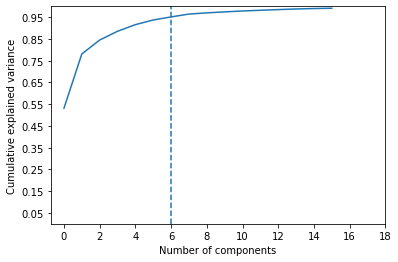

In [44]:
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data_zs)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 20, step=2))
plt.axvline(x=6, linestyle='--')
plt.ylim(0,1)

In [45]:
pca = PCA(n_components = 8)
# pca = PCA(n_components = .85, svd_solver = 'full')
princ_comps = pca.fit_transform(data_zs)
pca.n_components_

8

In [46]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.53169854 0.78121611 0.84502019 0.8854793  0.91587336 0.9373666
 0.95148805 0.96451998]


In [47]:
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

(1070994, 8)

In [48]:
data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,2.652116,-1.212644,0.301914,1.489034,-1.197228,-0.619431,0.871583,0.076804
1,68.630832,122.008093,-49.690690,32.808319,51.850863,-13.901049,33.087320,-20.060452
2,-0.085789,0.304139,0.155629,-0.173786,-0.026962,0.054281,-0.115516,0.318698
3,0.661719,-0.618777,0.089461,-0.136348,-0.262801,0.039222,0.025027,0.261317
4,128.292374,-51.798980,-43.596898,-17.493614,-2.555379,6.122271,3.979416,6.593080


In [49]:
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
count,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06
mean,-1.592262e-19,-1.125198e-17,-1.682490e-17,-2.797073e-17,-7.112102e-18,2.608655e-17,-1.306981e-18,-2.186706e-17
std,4.891465e+00,3.350864e+00,1.694457e+00,1.349318e+00,1.169501e+00,9.834610e-01,7.971608e-01,7.657916e-01
min,-7.205730e-01,-1.046063e+03,-7.952928e+02,-2.482179e+02,-4.574603e+02,-2.574754e+02,-1.697534e+02,-1.731475e+02
25%,-3.356721e-01,-3.333394e-01,-1.038973e-01,-1.953918e-01,-1.303979e-01,-6.902065e-02,-8.928147e-02,-4.255282e-02
50%,-9.511431e-02,-1.375652e-01,1.862750e-02,-3.234070e-02,-6.585325e-02,7.403015e-04,3.535314e-03,1.168263e-02
75%,5.833085e-02,6.812976e-02,2.542690e-01,7.428854e-02,3.769227e-02,1.214796e-01,6.683299e-02,9.920840e-02
max,2.557884e+03,2.022816e+03,1.040698e+03,5.260345e+02,5.238126e+02,4.160715e+02,2.652370e+02,2.320651e+02


In [50]:
data_pca_zs = (data_pca - data_pca.mean()) / data_pca.std()
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
count,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06
mean,-1.592262e-19,-1.125198e-17,-1.682490e-17,-2.797073e-17,-7.112102e-18,2.608655e-17,-1.306981e-18,-2.186706e-17
std,4.891465e+00,3.350864e+00,1.694457e+00,1.349318e+00,1.169501e+00,9.834610e-01,7.971608e-01,7.657916e-01
min,-7.205730e-01,-1.046063e+03,-7.952928e+02,-2.482179e+02,-4.574603e+02,-2.574754e+02,-1.697534e+02,-1.731475e+02
25%,-3.356721e-01,-3.333394e-01,-1.038973e-01,-1.953918e-01,-1.303979e-01,-6.902065e-02,-8.928147e-02,-4.255282e-02
50%,-9.511431e-02,-1.375652e-01,1.862750e-02,-3.234070e-02,-6.585325e-02,7.403015e-04,3.535314e-03,1.168263e-02
75%,5.833085e-02,6.812976e-02,2.542690e-01,7.428854e-02,3.769227e-02,1.214796e-01,6.683299e-02,9.920840e-02
max,2.557884e+03,2.022816e+03,1.040698e+03,5.260345e+02,5.238126e+02,4.160715e+02,2.652370e+02,2.320651e+02


In [51]:
data_pca_zs.head(20)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.542193,-0.361890,0.178177,1.103546,-1.023708,-0.629848,1.093359,0.100294
1,14.030730,36.410934,-29.325441,24.314736,44.335879,-14.134825,41.506459,-26.195705
2,-0.017539,0.090764,0.091846,-0.128796,-0.023055,0.055194,-0.144909,0.416168
3,0.135280,-0.184662,0.052796,-0.101049,-0.224712,0.039882,0.031395,0.341238
4,26.227799,-15.458395,-25.729131,-12.964779,-2.185016,6.225230,4.991986,8.609496
5,0.341755,0.013418,0.177757,0.493967,-0.503525,-0.318088,0.157177,0.581390
6,13.572359,-8.379956,-13.172769,-6.944839,-1.292266,3.330891,2.511159,4.388752
7,0.830278,-0.077074,-0.188714,0.692480,-0.644986,-0.444243,0.484574,0.721486
8,0.002295,0.088117,0.125848,0.141619,-0.041214,-0.094631,0.194483,0.134580
9,0.068899,0.191685,0.076660,0.307256,-0.005795,-0.191919,0.331744,0.098963


In [52]:
p=4
oop = 1/p
score1 = (((data_pca_zs).abs()**p).sum(axis=1))**oop
score1.head(10)

0     1.437703
1    56.552151
2     0.419136
3     0.364862
4    31.657715
5     0.716507
6    16.371445
7     1.056223
8     0.224829
9     0.393122
dtype: float64

In [53]:
score1.max()

695.1763434265756

(0.1, 2141801.567220657)

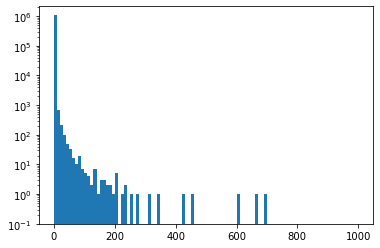

In [60]:
plt.hist(score1, bins =100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

In [63]:
from keras.models import Model
from keras.layers import Input, Dense
# placeholder for input
data_in = Input(shape=(8,))
# dimension of the encoded data. Choose 3
encoded_dim = 3
# encoded representation of the data
encoded = Dense(encoded_dim, activation='tanh')(data_in)
# reconstruction of the input
decoded = Dense(8,activation='tanh')(encoded)
# this model maps the input data to the reconstructed data
autoencoder = Model(data_in, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [64]:
%%time
autoencoder.fit(data_pca_zs,data_pca_zs, epochs=5, shuffle=True, validation_data=(data_pca_zs,data_pca_zs))


Train on 1070994 samples, validate on 1070994 samples
Epoch 1/5
1070994/1070994 [==============================] - 34s 32us/step - loss: 0.9350 - val_loss: 0.9303
Epoch 2/5
1070994/1070994 [==============================] - 33s 30us/step - loss: 0.9292 - val_loss: 0.9286
Epoch 3/5
1070994/1070994 [==============================] - 33s 30us/step - loss: 0.9284 - val_loss: 0.9279
Epoch 4/5
1070994/1070994 [==============================] - 33s 31us/step - loss: 0.9277 - val_loss: 0.9273
Epoch 5/5
1070994/1070994 [==============================] - 33s 30us/step - loss: 0.9275 - val_loss: 0.9272
Wall time: 2min 45s


In [65]:
%%time
pca_out = autoencoder.predict(data_pca_zs)
error = pca_out - data_pca_zs
p=3
oop=1/p
# score2 =np.power(np.sum(np.power(error, p), axis=1),oop)
score2 = ((error.abs()**p).sum(axis=1))**oop

Wall time: 6.81 s


In [66]:
score2.head(10)

0     1.268515
1    62.858025
2     0.179275
3     0.320232
4    34.118980
5     0.819866
6    17.520490
7     1.239355
8     0.264840
9     0.367595
dtype: float64

In [67]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores.head()

,score1,score2
0,1.437703,1.268515
1,56.552151,62.858025
2,0.419136,0.179275
3,0.364862,0.320232
4,31.657715,34.118980


In [68]:
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores.head(10)

,score1,score2,score1 rank,score2 rank
0,1.437703,1.268515,1046684.0,1055858.0
1,56.552151,62.858025,1070884.0,1070889.0
2,0.419136,0.179275,958854.0,925399.0
3,0.364862,0.320232,926564.0,1004230.0
4,31.657715,34.118980,1070724.0,1070728.0
5,0.716507,0.819866,1016940.0,1048213.0
6,16.371445,17.520490,1070350.0,1070382.0
7,1.056223,1.239355,1037483.0,1055513.0
8,0.224829,0.264840,587989.0,984354.0
9,0.393122,0.367595,945959.0,1015607.0


In [69]:
scores['final'] = (scores['score1 rank'] + scores['score2 rank'])/2
scores_sorted = scores.sort_values(by='final', ascending=False)
scores_sorted.head(20)

,score1,score2,score1 rank,score2 rank,final
917941,695.176343,770.918198,1070994.0,1070994.0,1070994.0
565391,665.789824,736.419263,1070993.0,1070993.0,1070993.0
85885,609.692513,672.329970,1070992.0,1070992.0,1070992.0
684703,458.769170,493.443147,1070991.0,1070991.0,1070991.0
67128,429.945501,475.475757,1070990.0,1070990.0,1070990.0
915468,346.362868,380.011243,1070989.0,1070989.0,1070989.0
690832,311.566653,348.204203,1070988.0,1070988.0,1070988.0
1059882,275.156189,301.795645,1070987.0,1070987.0,1070987.0
44247,250.106240,279.079757,1070986.0,1070986.0,1070986.0
116646,237.948046,261.768136,1070985.0,1070985.0,1070985.0


In [70]:
scores_sorted.tail(10)

,score1,score2,score1 rank,score2 rank,final
220547,0.025856,0.012469,379.0,296.0,337.5
694668,0.024308,0.012908,226.0,419.0,322.5
606685,0.020961,0.013288,42.0,564.0,303.0
693342,0.022089,0.012432,84.0,288.0,186.0
627153,0.019582,0.012539,14.0,313.0,163.5
606449,0.021271,0.012229,52.0,237.0,144.5
693318,0.023227,0.010452,161.5,5.5,83.5
693319,0.023227,0.010452,161.5,5.5,83.5
694708,0.021232,0.011676,51.0,104.0,77.5
626806,0.020647,0.011323,29.0,59.0,44.0


(0.1, 2141801.567220657)

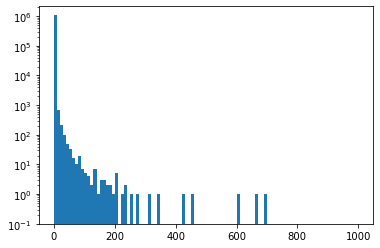

In [71]:
plt.hist(score1, bins =100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

(0.1, 2141877.243163918)

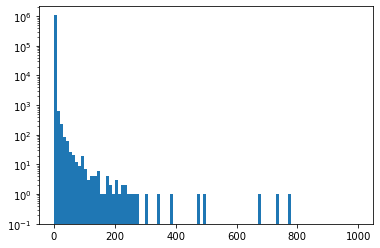

In [72]:
plt.hist(score2, bins =100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

D:\anaconda\envs\py37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='final', ylabel='Density'>

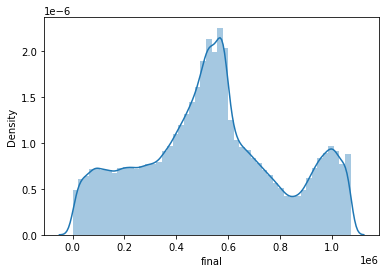

In [73]:
sns.distplot(scores['final'])

In [74]:
top_records = scores.sort_values(['final'], ascending = False).head(200).index
print(top_records)

Int64Index([ 917941,  565391,   85885,  684703,   67128,  915468,  690832,
            1059882,   44247,  116646,
            ...
             293329,  106722,  900078,  581145,   77123,  986427,  986411,
             986417,  986401,  986403],
           dtype='int64', length=200)


In [75]:
data_zs_top_n = data_zs.iloc[top_records]
data_zs_top_n.transpose()

,917941,565391,85885,684703,67128,915468,690832,1059882,44247,116646,...,293329,106722,900078,581145,77123,986427,986411,986417,986401,986403
r1,0.535636,512.765210,-0.141711,209.994955,81.640121,0.493989,0.796250,192.216004,0.549015,128.360902,...,2.765557,0.265972,17.208923,-0.275782,5.041475,34.063828,34.063828,34.063828,34.063828,34.063828
r2,28.155462,328.137810,471.007306,-0.159183,466.558209,70.819634,259.635741,0.010762,192.655103,1.933488,...,20.298258,20.255800,-0.159183,18.482434,4.856625,0.010762,0.010762,0.010762,0.010762,0.010762
r3,14.607118,93.955048,735.572763,-0.138220,133.630975,27.566296,135.075906,-0.097165,300.986032,-0.070398,...,5.717912,31.821827,-0.138220,29.053099,0.073757,-0.097165,-0.097165,-0.097165,-0.097165,-0.097165
r4,15.196011,861.816504,0.231539,20.610045,132.685538,0.119930,1.715713,134.407816,1.323284,57.266052,...,4.858054,0.804756,1.660919,0.006507,1.082508,23.950690,23.950690,23.950690,23.950690,23.950690
r5,323.460897,351.253292,501.836908,-0.024656,481.468505,10.105426,264.186396,0.079155,196.409332,0.585411,...,20.838332,19.361854,-0.024656,19.663815,0.662854,0.079155,0.079155,0.079155,0.079155,0.079155
r6,163.953849,98.049397,763.158673,-0.019945,134.402892,3.831221,133.907901,0.008570,298.699543,0.005005,...,5.804119,29.466102,-0.019945,29.925290,0.010192,0.008570,0.008570,0.008570,0.008570,0.008570
r7,26.318384,573.033245,0.094670,13.647789,91.448412,0.019575,1.142412,221.414912,0.866240,143.637487,...,3.342211,0.550070,1.044527,-0.055093,5.884507,39.455228,39.455228,39.455228,39.455228,39.455228
r8,641.545643,267.519796,383.932975,-0.040397,380.307754,7.675449,211.702818,0.160682,157.125534,1.721406,...,16.685420,16.650825,-0.040397,15.205847,4.103241,0.160682,0.160682,0.160682,0.160682,0.160682
r9,389.987533,89.549858,700.222268,-0.031106,127.312210,3.486722,128.687452,0.035790,286.595712,0.059271,...,5.568411,30.413330,-0.031106,27.778138,0.196474,0.035790,0.035790,0.035790,0.035790,0.035790
r1_zip5,1.492310,508.653468,-0.165887,224.806257,33.568954,1.217900,0.840457,315.781349,0.231394,84.637968,...,1.123044,-0.048438,36.329680,-0.311663,49.329254,38.120535,38.120535,38.120535,38.120535,38.120535


In [76]:
NY_data_orig.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


In [77]:
scores.head()

,score1,score2,score1 rank,score2 rank,final
0,1.437703,1.268515,1046684.0,1055858.0,1051271.0
1,56.552151,62.858025,1070884.0,1070889.0,1070886.5
2,0.419136,0.179275,958854.0,925399.0,942126.5
3,0.364862,0.320232,926564.0,1004230.0,965397.0
4,31.657715,34.118980,1070724.0,1070728.0,1070726.0


In [78]:
NY_data_with_scores = NY_data_orig.join(scores)
NY_data_with_scores.set_index('RECORD',inplace=True)
NY_data_with_scores.head()

,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1,score2,score1 rank,score2 rank,final
RECORD,,,,,,,,,,,,,,,,,,,,,
1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,...,8613000.0,NaN,FINAL,2010/11,AC-TR,1.437703,1.268515,1046684.0,1055858.0,1051271.0
2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,0,...,80690400.0,NaN,FINAL,2010/11,AC-TR,56.552151,62.858025,1070884.0,1070889.0,1070886.5
3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,...,40179510.0,NaN,FINAL,2010/11,AC-TR,0.419136,0.179275,958854.0,925399.0,942126.5
4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,...,15750000.0,NaN,FINAL,2010/11,AC-TR,0.364862,0.320232,926564.0,1004230.0,965397.0
5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,1260,...,107758350.0,NaN,FINAL,2010/11,AC-TR,31.657715,34.118980,1070724.0,1070728.0,1070726.0


In [79]:
NY_data_top_n = NY_data_with_scores.sort_values(['final'], ascending = False).head(100)
NY_data_top_n

,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1,score2,score1 rank,score2 rank,final
RECORD,,,,,,,,,,,,,,,,,,,,,
917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910,0,...,4.501180e+09,NaN,FINAL,2010/11,AC-TR,695.176343,770.918198,1070994.0,1070994.0,1070994.0
565392,3085900700,3,8590,700,NaN,U S GOVERNMENT OWNRD,V9,4,117,108,...,8.484847e+08,NaN,FINAL,2010/11,AC-TR,665.789824,736.419263,1070993.0,1070993.0,1070993.0
85886,1012540010,1,1254,10,NaN,PARKS AND RECREATION,Q1,4,4000,150,...,2.826018e+07,NaN,FINAL,2010/11,AC-TR,609.692513,672.329970,1070992.0,1070992.0,1070992.0
684704,4036590105,4,3659,105,NaN,W RUFERT,V0,1B,2,2,...,NaN,NaN,FINAL,2010/11,AC-TR,458.769170,493.443147,1070991.0,1070991.0,1070991.0
67129,1011110001,1,1111,1,NaN,CULTURAL AFFAIRS,Q1,4,840,0,...,2.465055e+09,NaN,FINAL,2010/11,AC-TR,429.945501,475.475757,1070990.0,1070990.0,1070990.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259235,3002580001,3,258,1,NaN,PARKS AND RECREATION,Q2,4,316,555,...,1.111122e+06,NaN,FINAL,2010/11,AC-TR,60.058304,67.672926,1070896.0,1070900.0,1070898.0
398288,3044520400,3,4452,400,NaN,HOME DEPOT USA INC,V3,1B,1545,955,...,NaN,NaN,FINAL,2010/11,AC-TR,60.649313,65.718189,1070898.0,1070896.0,1070897.0
23369,1004890001,1,489,1,NaN,"BROOME-THOMPSON, LLC",D9,2,200,100,...,NaN,NaN,FINAL,2010/11,AC-TR,62.177186,64.793348,1070901.0,1070893.0,1070897.0


In [80]:
data_zs_top_n['RECORD'] = (data_zs_top_n.index + 1).astype(int)
data_zs_top_n.set_index('RECORD',inplace=True)
data_zs_top_n

D:\anaconda\envs\py37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
RECORD,,,,,,,,,,,,,,,,,,,,,
917942,0.535636,28.155462,14.607118,15.196011,323.460897,163.953849,26.318384,641.545643,389.987533,1.492310,...,328.352098,0.783165,26.629905,7.710688,19.701153,379.852884,194.948448,45.398373,752.629322,444.211540
565392,512.765210,328.137810,93.955048,861.816504,351.253292,98.049397,573.033245,267.519796,89.549858,508.653468,...,75.315338,461.863588,304.868676,54.703561,938.887683,553.119217,175.573719,726.151150,354.612509,134.353747
85886,-0.141711,471.007306,735.572763,0.231539,501.836908,763.158673,0.094670,383.932975,700.222268,-0.165887,...,589.640208,-0.220949,467.560770,833.464564,0.025431,254.237338,624.123556,-0.037172,147.129115,581.421285
684704,209.994955,-0.159183,-0.138220,20.610045,-0.024656,-0.019945,13.647789,-0.040397,-0.031106,224.806257,...,-0.000002,274.043849,-0.163587,-0.088594,26.708414,-0.027038,-0.025624,23.584205,-0.038468,-0.037462
67129,81.640121,466.558209,133.630975,132.685538,481.468505,134.402892,91.448412,380.307754,127.312210,33.568954,...,107.119815,50.302149,463.144208,151.484805,32.554357,243.917715,109.908658,23.018041,145.739630,105.702266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986428,34.063828,0.010762,-0.097165,23.950690,0.079155,0.008570,39.455228,0.160682,0.035790,38.120535,...,-0.075839,48.634271,0.049725,-0.061525,18.749719,0.124000,0.014795,39.452234,0.276188,0.055836
986412,34.063828,0.010762,-0.097165,23.950690,0.079155,0.008570,39.455228,0.160682,0.035790,38.120535,...,-0.075839,48.634271,0.049725,-0.061525,18.749719,0.124000,0.014795,39.452234,0.276188,0.055836
986418,34.063828,0.010762,-0.097165,23.950690,0.079155,0.008570,39.455228,0.160682,0.035790,38.120535,...,-0.075839,48.634271,0.049725,-0.061525,18.749719,0.124000,0.014795,39.452234,0.276188,0.055836


In [81]:
NY_data_top_n.to_csv('NY_top new ele.csv', index=True)
data_zs_top_n.to_csv('data_zs_top new ele.csv', index=True)

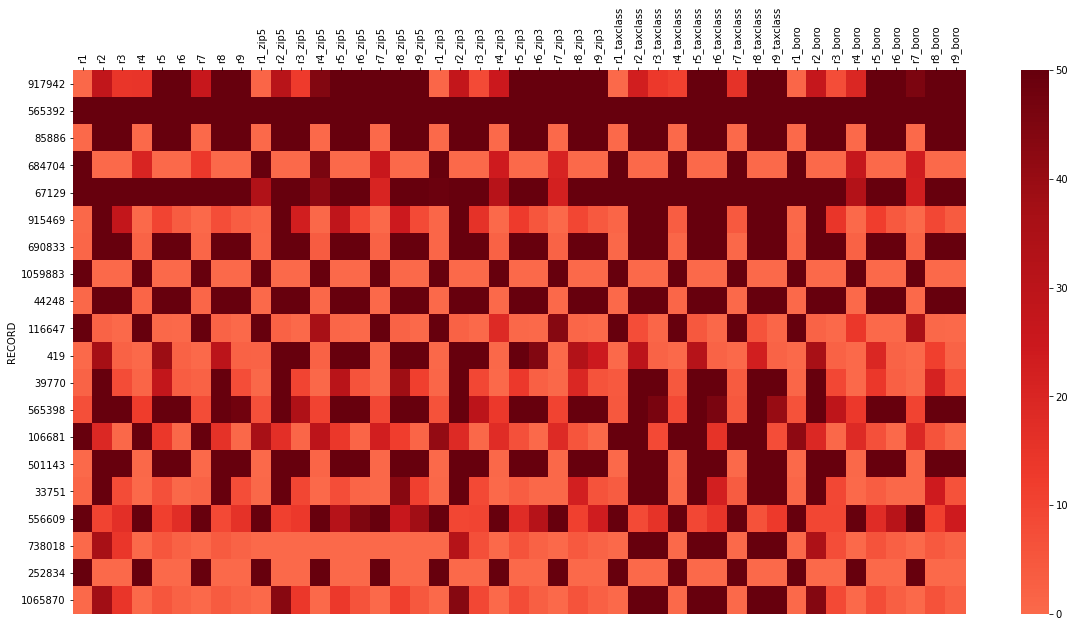

In [82]:
data_zs_top_n_abs = data_zs_top_n.abs()
data_heatmap = data_zs_top_n.abs().head(20)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [83]:
print('Duration: ', datetime.now() - start_time)

Duration:  0:25:22.575717
